## Goal

Our objective is to develop a machine learning (ML) model that is able to predict the objective function value for our problem of interest. The surface used for the analysis is obtained from exhaustive sampling (see here). Thus, we know the full objective function surface and global optimal solution. Additionally, there are no missing data for this problem.

The process to compute the values for each location is computationally expensive. If we are able to develop a model with good accuracy, we can replace the expensive forward simulations with the machine learning model. This notebook describes a process to find such a model.

Ideally, the machine learning model will be used in an online fashion, where we build the model as we acquire the points from an underlying optimization algorithm that attemps to find the global objective function. It should be noted that this is not easy in practice and the surfaces (see below) are obtained from an exhaustive evaluation process described earlier. In practice, when we apply the ML model, we may not have enough points and the accuracy of the model may suffer in practice. Additionally, the ML model developed here may not generalize to other problem instances.

## View Data
<img src='3d_surface.png' width=400 height=300/>
<p><center>Figure 1: 3D surface plot of data</center></p>

<img src='2d_contour.png' width=400 height=300/>
<p><center>Figure 1: Contour plot of data</center></p>



In [1]:
import numpy as np
import pandas as pd
#import pandas_profiling
import matplotlib.pyplot as plt
from sklearn import (ensemble, preprocessing, tree)
from sklearn.metrics import (auc, confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import (train_test_split, StratifiedKFold)
from yellowbrick.classifier import(ConfusionMatrix, ROCAUC)
from yellowbrick.model_selection import (LearningCurve)


In [219]:
num_rows, num_cols = 40, 40

### Gather Data

In [229]:
# read the file containing the data
data = pd.read_csv('obj_surface_data.csv')

## Data Exploration

In [246]:
# View statistics of the input data
data.describe()

,X1,X2,y
count,1600.000000,1600.000000,1600.000000
mean,20.500000,20.500000,67.597641
std,11.547005,11.547005,41.090698
min,1.000000,1.000000,7.098637
25%,10.750000,10.750000,37.517150
50%,20.500000,20.500000,57.329263
75%,30.250000,30.250000,92.644693
max,40.000000,40.000000,266.181500


### Pandas Profile Report

In [243]:
import pandas_profiling
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Create Feature Matrix and Target Data

In [ ]:
X = data.https://leetcode.com/abhi_jha25iloc[:,:2].values # feature matrix
y = data.iloc[:,-1].values # target 

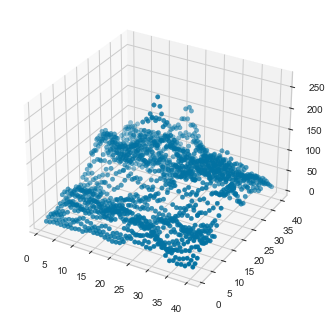

In [205]:
# plot the full surface
X = data.iloc[:,0:2]
y = data.iloc[:,-1]
plot_data(X, y)

In [132]:
X.iloc[:,0].values

array([ 1.,  2.,  3., ..., 38., 39., 40.])

## Sample Data

Create train and test splits with test_size = 0.33

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [225]:
# print the size of the train and test dataset
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)        

(1072, 2) (528, 2) (1072,) (528,)


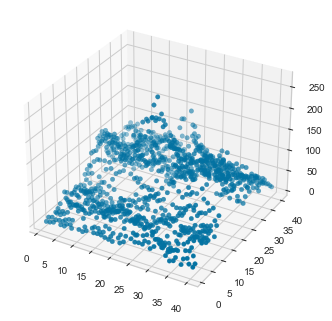

In [223]:
# plot the X_train and y_train data
plot_data(X_train, y_train)

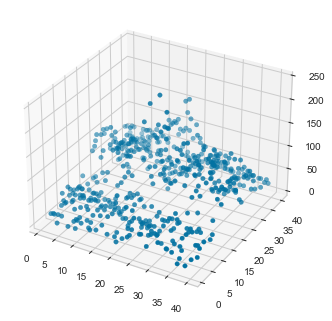

In [226]:
# plot the X_test and y_test data
plot_data(X_test, y_test)

In [235]:
data.describe()

,X1,X2,y
count,1600.000000,1600.000000,1600.000000
mean,20.500000,20.500000,67.597641
std,11.547005,11.547005,41.090698
min,1.000000,1.000000,7.098637
25%,10.750000,10.750000,37.517150
50%,20.500000,20.500000,57.329263
75%,30.250000,30.250000,92.644693
max,40.000000,40.000000,266.181500
